<a href="https://colab.research.google.com/github/PGM-Lab/deep_prob_modeling/blob/master/notebooks/pca_pcanl_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Modeling with Deep Neural Networks 


Here, we describe how to implement and make inference in such models using **Edward2**.



## Requiered packages

First, we will install  and import the required packages as follows.


In [1]:
!pip install tensorflow
!pip install keras
!pip install matplotlib
!pip install funcsigs


    100% |################################| 317kB 8.0MB/s ta 0:00:011
    100% |################################| 276kB 24.8MB/s ta 0:00:01
    100% |################################| 27.7MB 1.3MB/s ta 0:00:011    61% |###################             | 16.9MB 4.4MB/s eta 0:00:03
  Stored in directory: /Users/rcabanas/Library/Caches/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built pyyaml
    100% |################################| 14.4MB 3.5MB/s ta 0:00:011    82% |##########################      | 11.9MB 12.1MB/s eta 0:00:01
    100% |################################| 122kB 30.7MB/s ta 0:00:01
    100% |################################| 71kB 19.0MB/s ta 0:00:01


In [1]:
!rm util.py
!wget --no-cache --no-check-certificate https://raw.githubusercontent.com/PGM-Lab/deep_prob_modeling/master/experiments/util.py -O util.py
exec(open("util.py").read())
assert "preprocess_data" in dir()


rm: util.py: No such file or directory
--2019-06-21 11:54:22--  https://raw.githubusercontent.com/PGM-Lab/deep_prob_modeling/master/experiments/util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3752 (3.7K) [text/plain]
Saving to: ���util.py���

util.py             100%[===================>]   3.66K  --.-KB/s    in 0s      

2019-06-21 11:54:22 (36.9 MB/s) - ���util.py��� saved [3752/3752]



In [2]:
from tensorflow_probability import edward2 as ed
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# global parameters
elbo_evolution = {}
num_epochs = 1500

tf.reset_default_graph()


Using TensorFlow backend.


## Data 

For illustrating purposes, the MNIST dataset containg handwritten digits will be used. In particular we might obtain the data from the keras packages:

11493376/11490434 [==============================] - 3s 0us/step


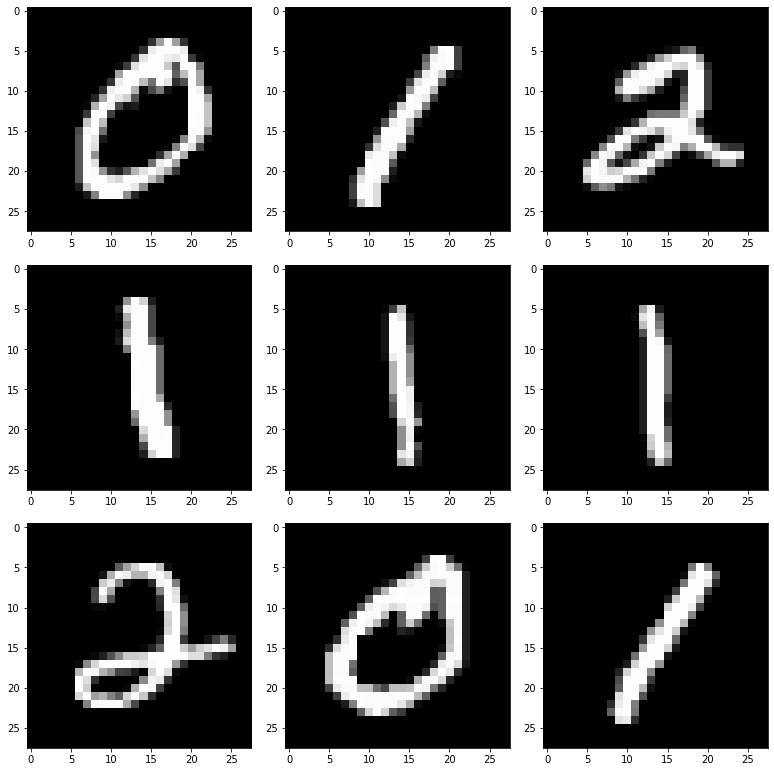

In [3]:
N = 1000                    #total number of observations    
num_pixels = 28*28          # pixels per image
C = list(range(0, 3))       # digits considered

(x_train, y_train), _ = mnist.load_data()
(x_train, y_train) = preprocess_data(x_train, y_train, N, C, num_pixels)

plot_imgs(x_train)

## Probabilistic PCA
### Model definition

The PPL implementig a PCA is shown below together with the correspondig Q-model for making variational inference.


In [5]:
# Global configuration
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01

# Model constants
k, d = 2, num_pixels


def pca(k,d,N):

    # Define local latent variables
    z = ed.Normal(loc=tf.zeros([k]), scale=1., sample_shape=N, name="z")

    # Define the weights
    beta = ed.Normal(loc=tf.zeros([k, d]), scale=1., name="beta")
    alpha = ed.Normal(loc=tf.zeros([d]), scale=1., name="alpha")

    # Define local random variables
    x = ed.Normal(loc=z @ beta + alpha, scale=1., name="x")  # N,k  @ k,d  +  N,d

    return z, (beta, alpha), x


def q_model(k, d, N):

    qz_loc = tf.Variable(tf.zeros([N, k]))
    qz_scale = tf.math.softplus(tf.Variable(tf.ones([N, k])))
    qz = ed.Normal(loc=qz_loc, scale=qz_scale, name="qz")

    qbeta_loc = tf.Variable(tf.zeros([k, d]))
    qbeta_scale = tf.math.softplus(tf.Variable(tf.ones([k, d])))
    qbeta = ed.Normal(loc=qbeta_loc, scale=qbeta_scale, name="qbeta")

    qalpha_loc = tf.Variable(tf.zeros([d]))
    qalpha_scale = tf.math.softplus(tf.Variable(tf.ones([d])))
    qalpha = ed.Normal(loc=qalpha_loc, scale=qalpha_scale, name="qalpha")

    return qz, (qbeta, qalpha)


print(pca)
print(q_model)

<function pca at 0x12f6ccc80>
<function q_model at 0x1303367b8>


### Inference



For making inference (of the parameters given the data), we must specify the ELBO function.


In [6]:
qz, (qbeta, qalpha) = q_model(k, d, N)

with ed.interception(set_values(beta=qbeta, alpha=qalpha, z=qz, x=x_train)):
    pz, (pbeta, palpha), px = pca(k, d, N)

energy = tf.reduce_sum(pbeta.distribution.log_prob(pbeta.value)) + \
         tf.reduce_sum(palpha.distribution.log_prob(palpha.value)) + \
         tf.reduce_sum(pz.distribution.log_prob(pz.value)) + \
         tf.reduce_sum(px.distribution.log_prob(px.value))

entropy = tf.reduce_sum(qbeta.distribution.log_prob(qbeta.value)) + \
          tf.reduce_sum(qalpha.distribution.log_prob(qalpha.value)) + \
          tf.reduce_sum(qz.distribution.log_prob(qz.value))

elbo = energy - entropy

print(elbo)

Tensor("sub:0", shape=(), dtype=float32)


Finally, the ELBO function is optimised.

In [7]:
with tf.Session() as sess:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    t = []
    train = optimizer.minimize(-elbo)
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(num_epochs+1):
        t.append(sess.run(elbo))
        sess.run(train)
        if verbose:
            if i % 10 == 0: print(".", end="", flush=True)
            if i % 100 == 0:
                str_elbo = str(t[-1] / 1000) + " k"
                print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)

        # Extract the posterior
                
        post = {"z": sess.run(qz.distribution.loc),
        "beta": sess.run(qbeta.distribution.loc),
        "alpha": sess.run(qalpha.distribution.loc)}
        
    elbo_evolution.update({"pca":t})


.
0 epochs	-2900418.304 k..........
100 epochs	-2839606.016 k..........
200 epochs	-2524019.2 k..........
300 epochs	-2154419.2 k..........
400 epochs	-1905656.448 k..........
500 epochs	-1736244.736 k..........
600 epochs	-1664075.008 k..........
700 epochs	-1619464.832 k..........
800 epochs	-1600418.176 k..........
900 epochs	-1588027.648 k..........
1000 epochs	-1572397.056 k..........
1100 epochs	-1548961.664 k..........
1200 epochs	-1506487.936 k..........
1300 epochs	-1445254.784 k..........
1400 epochs	-1388072.96 k..........
1500 epochs	-1342721.408 k

After the inference, we can plot the hidden representation:

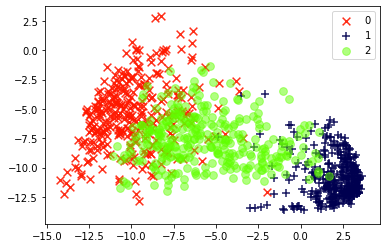

In [8]:

markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(C)):
    col = colors[c]
    plt.scatter(post["z"][y_train == C[c], 0], post["z"][y_train == C[c], 1], color=col,
                label=C[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend()

### Test

For testing our model, we will generate samples of **x** given the learnt posterior distributions.

set_values not interested in x.


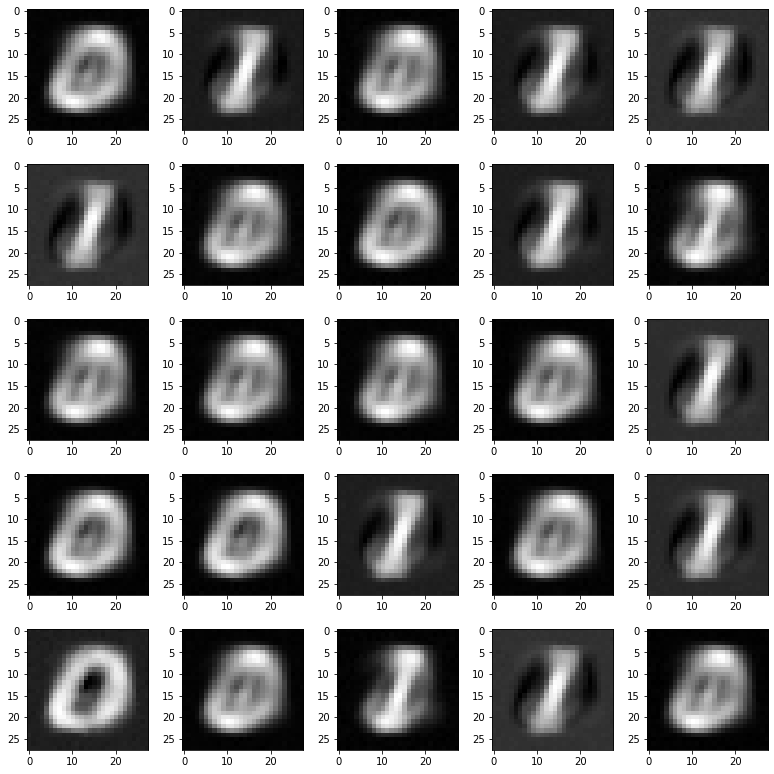

In [9]:

with ed.interception(set_values(**post)):
    generate = pca(k,d,N)

with tf.Session() as sess:
    _, _, x_gen = sess.run(generate)

plot_imgs(x_gen, nx=5, ny=5)


## Probabilistic Nonlinear PCA
### Model definition

In a (probabilistic) nonlinear PCA, the relationship between the __z__ and the **x** is defined by a ANN (i.e., the decoder). The code implementig a model of this kind is shown below together with the correspondig Q-model for making variational inference.


In [10]:
# Global configuration
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01


# Model constants
k, d0, d1 = 2, 100, num_pixels

# initial values
loc_init = 0.001
scale_init = 1



def nlpca(k, d0, d1, N, decoder):

    # Define local latent variables
    z = ed.Normal(loc=tf.ones([k]), scale=1., sample_shape=N, name="z")

    output, weights = decoder(z, k, d0, d1)

    # Define the observed variables
    x = ed.Normal(loc=output, scale=1., name="x")

    return z, weights, x


def decoder(z, k, d0, d1):

    beta0 = ed.Normal(tf.ones([k, d0]) * loc_init,
                      scale_init, name="beta0")
    alpha0 = ed.Normal(tf.ones([d0]) * loc_init,
                       scale_init, name="alpha0")

    h0 = tf.nn.relu(z @ beta0 + alpha0, name="h0")

    ######

    beta1 = ed.Normal(tf.ones([d0, d1]) * loc_init,
                      scale_init, name="beta1")
    alpha1 = ed.Normal(tf.ones([d1]) * loc_init,
                       scale_init, name="alpha1")

    output = h0 @ beta1 + alpha1

    return output, (beta0, alpha0, beta1, alpha1)


def q_model(k, d0, d1):

    qz_loc = tf.Variable(tf.ones([N, k]))
    qz_scale = tf.math.softplus(tf.Variable(tf.ones([N, k])))
    qz = ed.Normal(loc=qz_loc, scale=qz_scale, name="qz")

    ###

    qbeta0_loc = tf.Variable(tf.ones([k, d0]) * loc_init, name="qbeta0_loc")
    qbeta0_scale = tf.math.softplus(tf.Variable(tf.ones([k, d0]) * scale_init, name="qbeta0_scale"))
    qbeta0 = ed.Normal(qbeta0_loc, qbeta0_scale, name="qbeta0")

    qalpha0_loc = tf.Variable(tf.ones([d0]) * loc_init, name="qalpha0_loc")
    qalpha0_scale = tf.math.softplus(tf.Variable(tf.ones([d0]) * scale_init, name="qalpha0_scale"))
    qalpha0 = ed.Normal(qalpha0_loc, qalpha0_scale, name="qalpha0")

    ###

    qbeta1_loc = tf.Variable(tf.ones([d0, d1]) * loc_init, name="qbeta1_loc")
    qbeta1_scale = tf.math.softplus(tf.Variable(tf.ones([d0, d1]) * scale_init, name="qbeta1_scale"))
    qbeta1 = ed.Normal(qbeta1_loc, qbeta1_scale, name="qbeta1")

    qalpha1_loc = tf.Variable(tf.ones([d1]) * loc_init, name="qalpha1_loc")
    qalpha1_scale = tf.math.softplus(tf.Variable(tf.ones([d1]) * scale_init, name="qalpha1_scale"))
    qalpha1 = ed.Normal(qalpha1_loc, qalpha1_scale, name="qalpha1")

    ###

    return qz, (qbeta0, qalpha0, qbeta1, qalpha1)


### Inference



For making inference (of the parameters given the data), we must specify the ELBO function.


In [11]:
qz, qw = q_model(k, d0, d1)

qw_dict = {v.distribution.name[1:-1]: v for v in qw}

with ed.interception(set_values(z=qz, x=x_train, **qw_dict)):
    pz, pw, px = nlpca(k, d0, d1, N, decoder)

energy = tf.reduce_sum(pz.distribution.log_prob(pz.value)) + \
         tf.reduce_sum(px.distribution.log_prob(px.value)) + \
         tf.reduce_sum([tf.reduce_sum(v.distribution.log_prob(v.value)) for v in pw])

entropy = tf.reduce_sum(qz.distribution.log_prob(qz.value)) + \
          tf.reduce_sum([tf.reduce_sum(v.distribution.log_prob(v.value)) for v in qw])

elbo = energy - entropy

print(elbo)

Tensor("sub:0", shape=(), dtype=float32)


Finally, the ELBO function is optimised.

In [12]:
with tf.Session() as sess:
    optimizer = tf.train.AdamOptimizer(learning_rate)
    t = []
    train = optimizer.minimize(-elbo)
    init = tf.global_variables_initializer()
    sess.run(init)

    for i in range(num_epochs+1):
        t.append(sess.run(elbo))
        sess.run(train)
        if verbose:
            if i % 10 == 0: print(".", end="", flush=True)
            if i % 100 == 0:
                str_elbo = str(t[-1] / 1000) + " k"
                print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)

    # extract the inferred parameters
    postw = {k: sess.run(v) for k, v in qw_dict.items()}
    post = {"z": sess.run(qz.distribution.loc), **postw}
    
    elbo_evolution.update({"nlpca":t}) 


.
0 epochs	-3292531.2 k..........
100 epochs	-2169630.72 k..........
200 epochs	-1905043.2 k..........
300 epochs	-1832687.744 k..........
400 epochs	-1773218.56 k..........
500 epochs	-1723900.544 k..........
600 epochs	-1623789.696 k..........
700 epochs	-1485202.816 k..........
800 epochs	-1425973.376 k..........
900 epochs	-1366513.152 k..........
1000 epochs	-1303027.456 k..........
1100 epochs	-1244847.232 k..........
1200 epochs	-1216888.448 k..........
1300 epochs	-1190124.928 k..........
1400 epochs	-1177153.792 k..........
1500 epochs	-1167779.456 k

After the inference, we can plot the hidden representation:

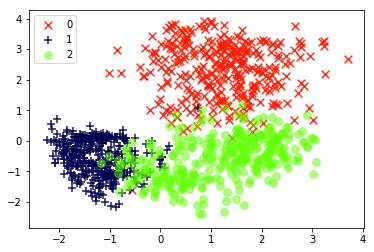

In [13]:

markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(C)):
    col = colors[c]
    plt.scatter(post["z"][y_train == C[c], 0], post["z"][y_train == C[c], 1], color=col,
                label=C[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend()

### Test

For testing our model, we will generate samples of **x** given the learnt posterior distributions.

set_values not interested in x.


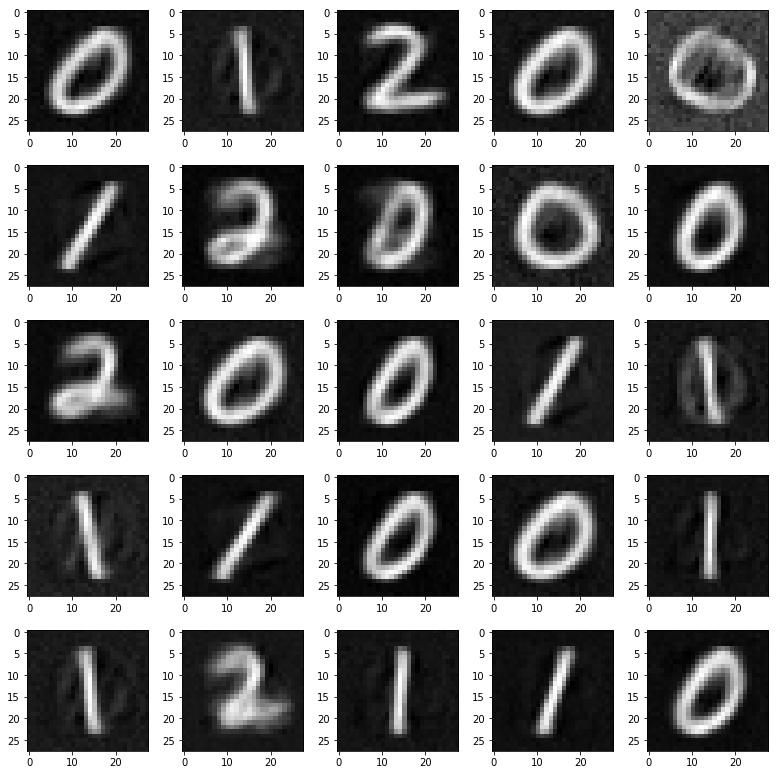

In [21]:
with ed.interception(set_values(**post)):
    generate = nlpca(k, d0, d1, N, decoder)

with tf.Session() as sess:
    _, _, x_gen = sess.run(generate)

plot_imgs(x_gen, nx=5, ny=5)



## Variational autoencoder
### Model definition

The code implementig a variational autoencoder is shown below together with the correspondig Q-model for making variational inference. Now we must define the ANNs for the decoder but for the encoder as well.


In [22]:
# Global configuration
tf.reset_default_graph()
tf.set_random_seed(1234)
verbose = True
learning_rate = 0.01


# Model constants
k, d0, dx = 2, 100, num_pixels

# initial values
scale_init_encoder = 0.01
scale_epsilon = 0.01


def vae(k, d0, dx, N, decoder):

    # Define local latent variables
    z = ed.Normal(loc=tf.zeros(k), scale=tf.ones(k), sample_shape=N, name="z")

    output, weights = decoder(z, k, d0, dx)

    # Define the observed variables
    x = ed.Normal(loc=output, scale=1., name="x")

    return z, weights, x


def decoder(z, k, d0, dx):  # z -> x (k -> d0 -> 2*dx)

    beta0 = ed.Normal(tf.zeros([k, d0]),
                      1., name="beta0")
    alpha0 = ed.Normal(tf.zeros([d0]),
                       1., name="alpha0")

    h0 = tf.nn.relu(z @ beta0 + alpha0, name="h0")

    ######

    beta1 = ed.Normal(tf.zeros([d0, dx]) ,
                      1., name="beta1")
    alpha1 = ed.Normal(tf.zeros([dx]),
                       1., name="alpha1")

    output = h0 @ beta1 + alpha1


    #####

    return output, (beta0, alpha0, beta1, alpha1)

def predictive_encoder(x, beta0, alpha0, beta1, alpha1):

    h0 = tf.nn.relu(x @ beta0 + alpha0, name="encoder_h0")
    output = h0 @ beta1 + alpha1

    return output

def encoder(x, k, d0, dx):
    
    beta0 = tf.Variable(tf.random_normal([dx, d0],stddev=scale_init_encoder), name="encoder_beta0")
    alpha0 = tf.Variable(tf.zeros([d0]), name="encoder_alpha0")
    h0 = tf.nn.relu(x @ beta0 + alpha0, name="encoder_h0")

    ######

    beta1 = tf.Variable(tf.random_normal([d0, 2 * k],stddev=scale_init_encoder), name="encoder_beta1")
    alpha1 = tf.Variable(tf.zeros([2 * k]), name="encoder_alpha1")
    output = h0 @ beta1 + alpha1

    return output


def q_model(k, d0, dx, x, encoder):

    output = encoder(x, k, d0, dx)


    qz_loc = output[:,:k]
    qz_scale = output[:,k:]

    qz = ed.Normal(loc=qz_loc, scale=tf.nn.softplus(qz_scale+tf.math.log(tf.math.expm1(scale_init_encoder))) + scale_epsilon, name="qz")

    ###

    qbeta0_loc = tf.Variable(tf.zeros([k, d0]) , name="qbeta0_loc")
    qbeta0_scale = tf.math.softplus(tf.Variable(tf.zeros([k, d0]), name="qbeta0_scale")+tf.math.log(tf.math.expm1(scale_init_encoder)))
    qbeta0 = ed.Normal(qbeta0_loc, qbeta0_scale + scale_epsilon, name="qbeta0")

    qalpha0_loc = tf.Variable(tf.zeros([d0]), name="qalpha0_loc")
    qalpha0_scale = tf.math.softplus(tf.Variable(tf.zeros([d0]), name="qalpha0_scale")+tf.math.log(tf.math.expm1(scale_init_encoder)))
    qalpha0 = ed.Normal(qalpha0_loc, qalpha0_scale + scale_epsilon, name="qalpha0")

    ###

    qbeta1_loc = tf.Variable(tf.zeros([d0, dx]), name="qbeta1_loc")
    qbeta1_scale = tf.math.softplus(tf.Variable(tf.zeros([d0, dx]), name="qbeta1_scale")+tf.math.log(tf.math.expm1(scale_init_encoder)))
    qbeta1 = ed.Normal(qbeta1_loc, qbeta1_scale + scale_epsilon, name="qbeta1")

    qalpha1_loc = tf.Variable(tf.zeros([dx]) , name="qalpha1_loc")
    qalpha1_scale = tf.math.softplus(tf.Variable(tf.zeros([dx]), name="qalpha1_scale")+tf.math.log(tf.math.expm1(scale_init_encoder)))
    qalpha1 = ed.Normal(qalpha1_loc, qalpha1_scale + scale_epsilon, name="qalpha1")


    ###

    return qz, (qbeta0, qalpha0, qbeta1, qalpha1)






### Batched data

For using the SVI inference algorithm, we might split the data into batches.

In [23]:
M = 100
batches = np.array_split(x_train, N / M)
batch = tf.placeholder(dtype=tf.float32, name="batch", shape=[M, num_pixels])


### Inference



For making inference (of the parameters given the data), we must specify the ELBO function.


In [24]:
qz, qw = q_model(k, d0, dx, batch, encoder)

qw_dict = {v.distribution.name[1:-1]: v for v in qw}

with ed.interception(set_values(z=qz, x=batch, **qw_dict)):
    pz, pw, px = vae(k, d0, dx, M, decoder)

energy = N/M*tf.reduce_sum(pz.distribution.log_prob(pz.value)) + \
         N/M*tf.reduce_sum(px.distribution.log_prob(px.value)) + \
         tf.reduce_sum([tf.reduce_sum(v.distribution.log_prob(v.value)) for v in pw])

entropy = N/M*tf.reduce_sum(qz.distribution.log_prob(qz.value)) + \
          tf.reduce_sum([tf.reduce_sum(v.distribution.log_prob(v.value)) for v in qw])

elbo = energy - entropy

print(elbo)

Tensor("sub:0", shape=(), dtype=float32)


Finally, the ELBO function is optimised.

In [25]:
with tf.Session() as sess:
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(-elbo)
    init = tf.global_variables_initializer()
    sess.run(init)
    t = []
    for i in range(num_epochs+1):
        for j in range(N//M):
            elbo_ij = sess.run(elbo, feed_dict = {batch: batches[j]})
            if j==(N//M-1):
                t.append(elbo_ij)

            sess.run(train, feed_dict = {batch: batches[j]})


            if verbose:

                if i % 10 == 0 and j==N//M-1: print(".", end="", flush=True)
                if i % 50 == 0 and j==N//M-1:
                    str_elbo = str(t[-1] / 1000) + " k"
                    print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)

        weights_encoder = [sess.run(get_tfvar("encoder_"+name)) for name in ["beta0", "alpha0", "beta1", "alpha1"]]
        postw = {k: sess.run(v) for k, v in qw_dict.items()}
        post = {"z": sess.run(predictive_encoder(x_train, *weights_encoder)[:,:k]), **postw}
        
        elbo_evolution.update({"vae":t})


.
0 epochs	-1739301.248 k.....
50 epochs	-919544.256 k.....
100 epochs	-894773.312 k.....
150 epochs	-922566.848 k.....
200 epochs	-887028.672 k.....
250 epochs	-874539.136 k.....
300 epochs	-928598.592 k.....
350 epochs	-858876.48 k.....
400 epochs	-831753.408 k.....
450 epochs	-846377.92 k.....
500 epochs	-840305.6 k.....
550 epochs	-799885.184 k.....
600 epochs	-843495.296 k.....
650 epochs	-796091.008 k.....
700 epochs	-776130.304 k.....
750 epochs	-825518.592 k.....
800 epochs	-787773.696 k.....
850 epochs	-779056.832 k.....
900 epochs	-798695.488 k.....
950 epochs	-780958.464 k.....
1000 epochs	-738426.24 k.....
1050 epochs	-761229.248 k.....
1100 epochs	-738296.256 k.....
1150 epochs	-728292.416 k.....
1200 epochs	-772559.744 k.....
1250 epochs	-783673.984 k.....
1300 epochs	-739996.544 k.....
1350 epochs	-741030.08 k.....
1400 epochs	-756058.368 k.....
1450 epochs	-723424.576 k.....
1500 epochs	-724569.344 k

After the inference, we can plot the hidden representation:

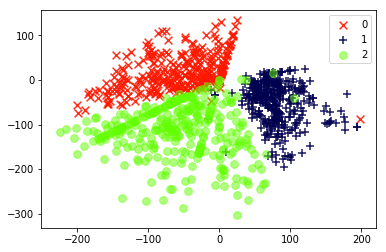

In [26]:
markers = ["x", "+", "o"]
colors = [plt.get_cmap("gist_rainbow")(0.05),
          plt.get_cmap("gnuplot2")(0.08),
          plt.get_cmap("gist_rainbow")(0.33)]
transp = [0.9, 0.9, 0.5]

fig = plt.figure()

for c in range(0, len(C)):
    col = colors[c]
    plt.scatter(post["z"][y_train == C[c], 0], post["z"][y_train == C[c], 1], color=col,
                label=C[c], marker=markers[c], alpha=transp[c], s=60)
    plt.legend()

### Test

For testing our model, we will generate samples of **x** given the learnt posterior distributions.

set_values not interested in x.


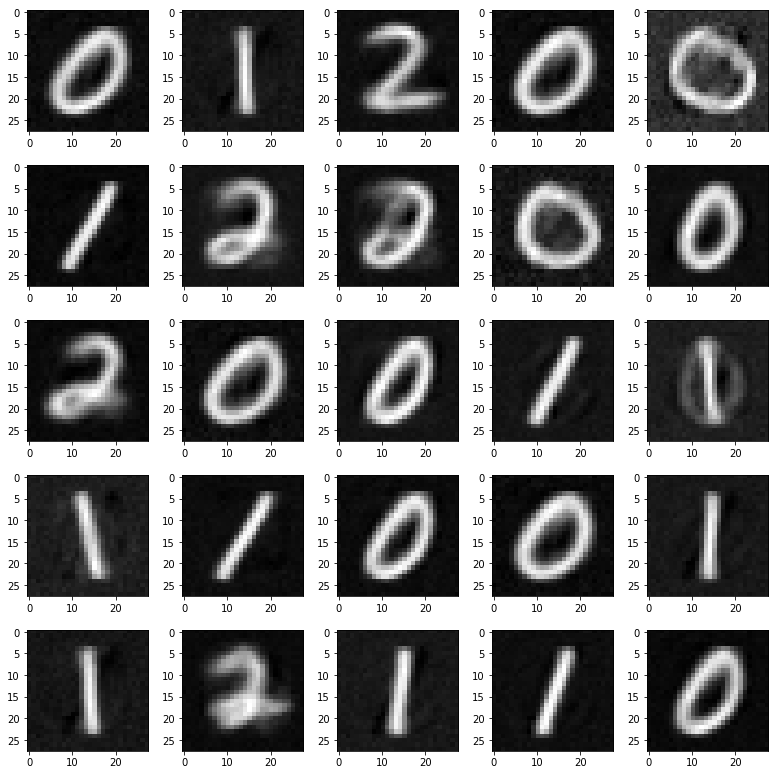

In [27]:
with ed.interception(set_values(**post)):
    generate = vae(k, d0, dx, N, decoder)
    
with tf.Session() as sess:
    _, _, x_gen = sess.run(generate)

plot_imgs(x_gen, nx=5, ny=5)

In [28]:
elbo_evolution

{'pca': [-2903808300.0,
  -2903708400.0,
  -2903417900.0,
  -2903248100.0,
  -2902783000.0,
  -2902697700.0,
  -2902109700.0,
  -2901824800.0,
  -2901719300.0,
  -2901724200.0,
  -2901313300.0,
  -2900806000.0,
  -2900675800.0,
  -2900300300.0,
  -2899885000.0,
  -2899369700.0,
  -2899548400.0,
  -2899446500.0,
  -2899241700.0,
  -2898553000.0,
  -2897341200.0,
  -2897756700.0,
  -2897974000.0,
  -2897142300.0,
  -2897428700.0,
  -2896545300.0,
  -2896306200.0,
  -2896475100.0,
  -2896024600.0,
  -2895917600.0,
  -2895029200.0,
  -2895495700.0,
  -2895335700.0,
  -2894140700.0,
  -2893948000.0,
  -2893735200.0,
  -2894003700.0,
  -2893098800.0,
  -2893163300.0,
  -2892782800.0,
  -2892277500.0,
  -2891645400.0,
  -2892015400.0,
  -2891757800.0,
  -2891509000.0,
  -2891206700.0,
  -2890401000.0,
  -2890046500.0,
  -2890312200.0,
  -2889878300.0,
  -2889987600.0,
  -2889266700.0,
  -2888832500.0,
  -2888124000.0,
  -2888262400.0,
  -2888126200.0,
  -2887092000.0,
  -2886834000.0,
  -2886

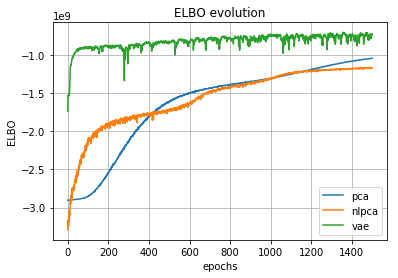

In [31]:
for k,v in elbo_evolution.items():
    plt.plot(range(len(v)), v)


plt.xlabel('epochs')
plt.ylabel('ELBO')
plt.title('ELBO evolution')
plt.legend(elbo_evolution.keys())
plt.grid(True)
plt.show()